## Defining a basic simulation on a real graph

### Imports
Import the required libraries

In [1]:
import opentnsim
print('This notebook has been tested with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook has been tested with OpenTNSim version 1.1.2


In [2]:
# Used for mathematical functions
# package(s) related to time, space and id
import math             
import datetime
import time
import platform
import random
import os
import pathlib
import warnings

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim
import opentnsim.core as core


# Used for making the graph to visualize our problem
import networkx as nx  
import pandas as pd

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


In [3]:
src_dir = pathlib.Path(opentnsim.__file__).parent.parent

# Graph location
location_graph = src_dir / "notebooks"
name_graph = location_graph / "Shape-Files" / "Rotterdam-Antwerpen-corridor" / "edges_2.shp"


### Create graph

We will now visualize the network based on the file edges_2.shp
**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_83088/3260709393.py:2: DeprecationWarning:

read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.



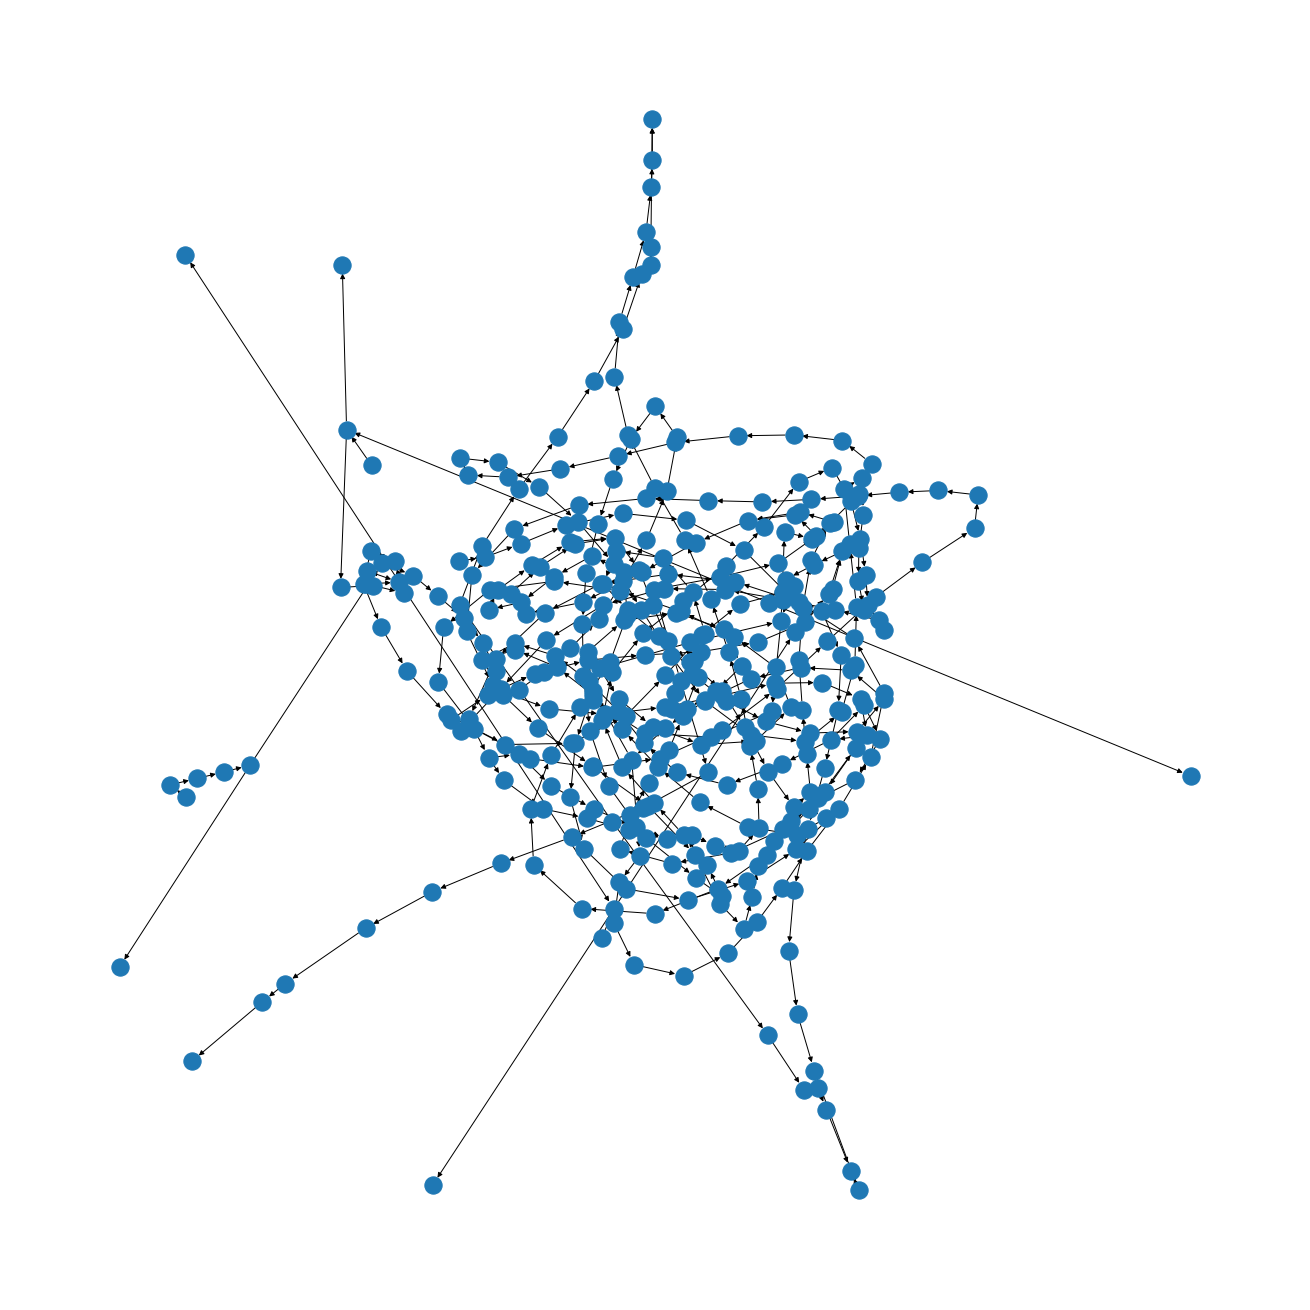

In [4]:
# Read the shape-file
FG = nx.read_shp(str(name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

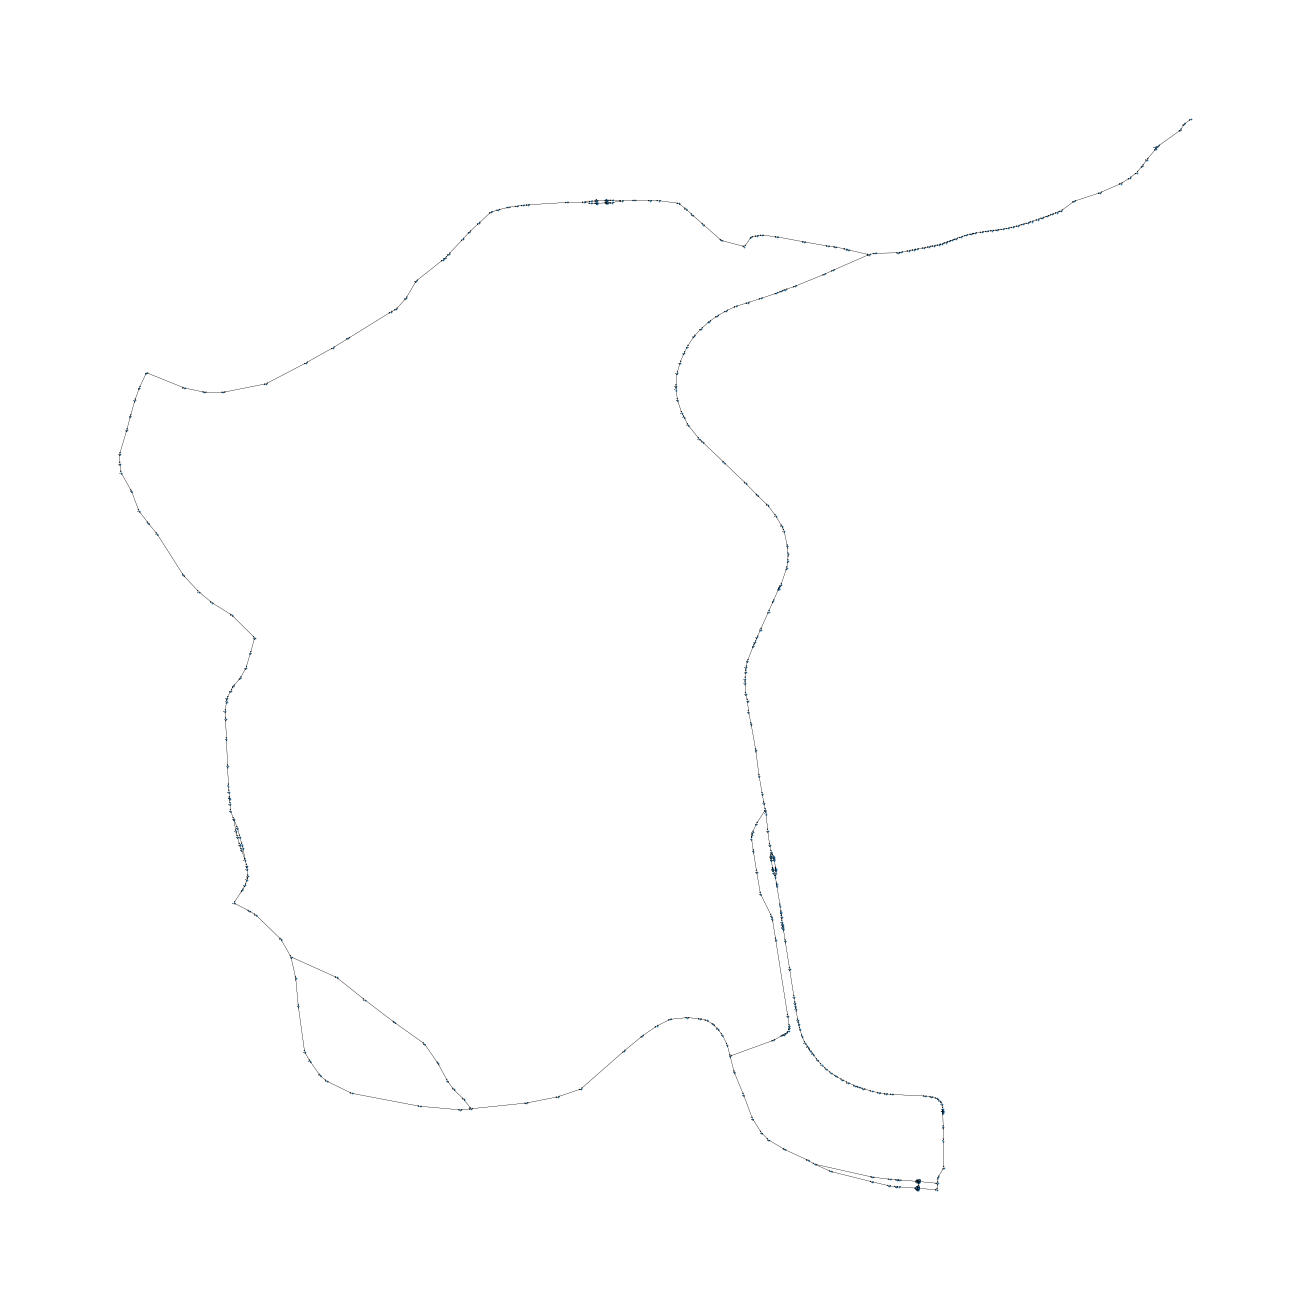

In [5]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    orig = shapely.geometry.shape(orig)
    dest = shapely.geometry.shape(dest)
    
    distance = wgs84.inv(orig.x, orig.y, 
                         dest.x, dest.y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(18,18))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), with_labels=True, node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

### Create vessels
Vessel without graph, but with shortest path.

In [6]:
# Make a class out of mix-ins
TransportResource = type(
    'TransportResource', 
                         (core.Identifiable, core.Movable, 
                          core.HasResource, core.Routeable, core.HasContainer, core.ExtraMetadata), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(4.0092314, 51.4598245),  # lon, lat
               "capacity": 1_000,
               "v": 1}

# create the transport processing resource
vessel = TransportResource(**data_vessel)


### Define paths

In [7]:
# select 2 nodes on the graph
source = 272
target = 373
path = nx.dijkstra_path(FG, source, target)
print(path)

[272, 209, 208, 210, 278, 277, 354, 353, 373]


### Run simulation

Now we run a simulation for the two constructed paths

In [8]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        print(vessel.geometry)
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env
vessel.route = path

# Start the simulation
env.process(start(env, vessel))
env.run()

print("Simulation of path {} took {} seconds".format(path, int(env.now - env.epoch)))

POINT (4.0132076 51.4431779)
Simulation of path [272, 209, 208, 210, 278, 277, 354, 353, 373] took 1881 seconds


# Output
We can now show the output of the the vessel. It should sail from source to target in about half an hour. 

In [10]:
pd.DataFrame(vessel.log)

,Message,Timestamp,Value,Geometry
0,Start sailing,2022-05-29 15:15:20.000000,,POINT (4.0092314 51.4598245)
1,Sailing from node 272 to node 209 start,2022-05-29 15:15:20.000000,0,POINT (4.0092314 51.4598245)
2,Sailing from node 272 to node 209 stop,2022-05-29 15:20:40.482582,0,POINT (4.0102066 51.4570091)
3,Sailing from node 209 to node 208 start,2022-05-29 15:20:40.482582,0,POINT (4.0102066 51.4570091)
4,Sailing from node 209 to node 208 stop,2022-05-29 15:25:28.857297,0,POINT (4.0111091 51.4544792)
5,Sailing from node 208 to node 210 start,2022-05-29 15:25:28.857297,0,POINT (4.0111091 51.4544792)
6,Sailing from node 208 to node 210 stop,2022-05-29 15:27:30.671188,0,POINT (4.0115461 51.4534189)
7,Sailing from node 210 to node 278 start,2022-05-29 15:27:30.671188,0,POINT (4.0115461 51.4534189)
8,Sailing from node 210 to node 278 stop,2022-05-29 15:34:48.512212,0,POINT (4.0124113 51.4495208)
9,Sailing from node 278 to node 277 start,2022-05-29 15:34:48.512212,0,POINT (4.0124113 51.4495208)
